In [1]:
import numpy as np
import xarray as xr
import pandas as pd
from salishsea_tools import viz_tools, places, visualisations
from matplotlib import pyplot as plt, dates
from datetime import datetime, timedelta
from calendar import month_name
from scipy.io import loadmat
from tqdm.notebook import tqdm
from salishsea_tools import nc_tools
from dask.diagnostics import ProgressBar
import cmocean

%matplotlib inline

In [2]:
plt.rcParams.update({'font.size': 12, 'axes.titlesize': 'medium'})

##### Load files from monthly averages

In [3]:
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)} 
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2007, 2021), ['PPDIAT','PPPHY','PPMRUB']


# Temporary list dict
data = {}

# Permanent aggregate dict
aggregates = {var: {} for var in variables}

# Loop through years
for year in [2007,2008,2009,2010,2011,2012,2015,2016,2017,2018,2019,2020]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r/SalishSea_1m_{datestr}_{datestr}'
        
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_prod_T.nc') as ds:
            for var in ['PPDIAT','PPPHY','PPMRUB']:
                data[var].append(np.ma.masked_where(tmask == 0,\
                            ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data)
    
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)

# Loop through years for wrap files
for year in [2013,2014,]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r_wrap/SalishSea_1m_{datestr}_{datestr}'
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_prod_T.nc') as ds:
            for var in ['PPDIAT','PPPHY','PPMRUB']:
                data[var].append(np.ma.masked_where(tmask == 0,\
                            ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data)
    
    # Concatenate months
    for var in variables: aggregates[var][year] = np.concatenate(data[var]).mean(axis=0)

# Add total grazing fields
aggregates['PProductivity'] = {}
variables.append('PProductivity')
for year in years:
    aggregates['PProductivity'][year] = sum(aggregates[var][year] for var in ['PPDIAT','PPPHY','PPMRUB'])


   
# Calculate climatological mean and anomalies
for var in variables:
    aggregates[var]['mean'] = np.concatenate([aggregates[var][year][None, ...] for year in years]).mean(axis=0)
    for year in years: aggregates[var][year] = aggregates[var][year] - aggregates[var]['mean']

In [4]:
#years, months, data
monthly_array_ppdiat_depthint_slice = np.zeros([14,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)}
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2007, 2021), ['PPDIAT']



# Temporary list dict
data = {}
# Permanent aggregate dict
#aggregates = {var: {} for var in variables}
#monthlydat = {var: {} for var in variables}

# Loop through years
for year in [2007,2008,2009,2010,2011,2012,2015,2016,2017,2018,2019,2020]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r/SalishSea_1m_{datestr}_{datestr}'
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_prod_T.nc') as ds:
            q = np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data
            q2 = q[0,:,:]
            monthly_array_ppdiat_depthint_slice[year-2007,month-1,:,:] = q2 #year2015 is index 0 along 1st dimension
            for var in ['PPDIAT']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data)
    
# Loop through years for wrap files
for year in [2013,2014]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r_wrap/SalishSea_1m_{datestr}_{datestr}'
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_prod_T.nc') as ds:
            q = np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data
            q2 = q[0,:,:]
            monthly_array_ppdiat_depthint_slice[year-2007,month-1,:,:] = q2 #year2015 is index 0 along 1st dimension
            for var in ['PPDIAT']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data)
    
    

In [5]:
monthly_array_ppdiat_depthint_slice[monthly_array_ppdiat_depthint_slice == 0 ] = np.nan
monthly_array_ppdiat_depthint_slicemean = \
np.nanmean(np.nanmean(monthly_array_ppdiat_depthint_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_ppdiat_depthint_slicemean))

(14, 12)


In [6]:
#years, months, data
monthly_array_ppflag_depthint_slice = np.zeros([14,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)}
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2007, 2021), ['PPPHY']


# Temporary list dict
data = {}
# Permanent aggregate dict
#aggregates = {var: {} for var in variables}
#monthlydat = {var: {} for var in variables}

# Loop through years
for year in [2007,2008,2009,2010,2011,2012,2015,2016,2017,2018,2019,2020]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r/SalishSea_1m_{datestr}_{datestr}'
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_prod_T.nc') as ds:
            q = np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data
            q2 = q[0,:,:]
            monthly_array_ppflag_depthint_slice[year-2007,month-1,:,:] = q2 #year2015 is index 0 along 1st dimension
            for var in ['PPPHY']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data)
    
# Loop through years for wrap files
for year in [2013,2014]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r_wrap/SalishSea_1m_{datestr}_{datestr}'
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_prod_T.nc') as ds:
            q = np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data
            q2 = q[0,:,:]
            monthly_array_ppflag_depthint_slice[year-2007,month-1,:,:] = q2 #year2015 is index 0 along 1st dimension
            for var in ['PPPHY']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data)
    
    

In [7]:
monthly_array_ppflag_depthint_slice[monthly_array_ppflag_depthint_slice == 0 ] = np.nan
monthly_array_ppflag_depthint_slicemean = \
np.nanmean(np.nanmean(monthly_array_ppflag_depthint_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_ppflag_depthint_slicemean))

(14, 12)


In [8]:
#years, months, data
monthly_array_ppcil_depthint_slice = np.zeros([14,12,50,50])
# Load monthly averages
mask = xr.open_dataset('/data/eolson/results/MEOPAR/NEMO-forcing-new/grid/mesh_mask201702.nc')
slc = {'y': slice(450,500), 'x': slice(250,300)}
e3t, tmask = [mask[var].isel(z=slice(None, 27),**slc).values for var in ('e3t_0', 'tmask')]
years, variables = range(2007, 2021), ['PPMRUB']


# Temporary list dict
data = {}
# Permanent aggregate dict
#aggregates = {var: {} for var in variables}
#monthlydat = {var: {} for var in variables}

# Loop through years
for year in [2007,2008,2009,2010,2011,2012,2015,2016,2017,2018,2019,2020]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r/SalishSea_1m_{datestr}_{datestr}'
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_prod_T.nc') as ds:
            q = np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data
            q2 = q[0,:,:]
            monthly_array_ppcil_depthint_slice[year-2007,month-1,:,:] = q2 #year2015 is index 0 along 1st dimension
            for var in ['PPMRUB']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data)
    
# Loop through years for wrap files
for year in [2013,2014]:
    # Initialize lists
    for var in variables: data[var] = []
    # Load monthly averages
    for month in range(1, 13):
        datestr = f'{year}{month:02d}'
        prefix = f'/data/sallen/results/MEOPAR/v201905r_wrap/SalishSea_1m_{datestr}_{datestr}'
        
        # Load grazing variables
        with xr.open_dataset(prefix + '_prod_T.nc') as ds:
            q = np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data
            q2 = q[0,:,:]
            monthly_array_ppcil_depthint_slice[year-2007,month-1,:,:] = q2 #year2015 is index 0 along 1st dimension
            for var in ['PPMRUB']:
                data[var].append(np.ma.masked_where(tmask == 0, ds[var].isel(deptht=slice(None, 27), **slc).values * e3t).sum(axis=1).data)
    
    

In [9]:
monthly_array_ppcil_depthint_slice[monthly_array_ppcil_depthint_slice == 0 ] = np.nan
monthly_array_ppcil_depthint_slicemean = \
np.nanmean(np.nanmean(monthly_array_ppcil_depthint_slice, axis = 2),axis = 2)
print(np.shape(monthly_array_ppcil_depthint_slicemean))

(14, 12)


In [10]:
PProd=(monthly_array_ppdiat_depthint_slicemean+monthly_array_ppflag_depthint_slicemean+monthly_array_ppcil_depthint_slicemean)*86400

In [11]:
PProd

array([[ 1.14778417,  1.7699756 ,  2.5892086 , 15.79789829, 18.40007165,
        15.43369512, 17.21829652, 15.38667253, 13.0400651 ,  1.73135634,
         0.98757968,  0.61767839],
       [ 1.02975187,  2.09370932,  4.38455867, 18.99990563, 20.81507893,
        16.40842553, 18.16126507, 13.68271194, 11.88244072,  2.60517331,
         0.83410557,  0.68925512],
       [ 1.16641331,  2.13465129,  3.48684422, 20.78461823, 17.40894107,
        16.96057262, 20.6131062 , 15.46506722, 10.4879384 ,  2.60982677,
         0.79018524,  0.96480607],
       [ 0.85285682,  1.88361161,  5.25559241, 17.05153021, 17.39030246,
        18.14666084, 20.29396255, 16.22919496,  9.95454258,  2.68386086,
         1.06423204,  0.63441224],
       [ 0.99808804,  1.72979417,  2.3285584 ,  7.99212763, 18.31846565,
        17.43197714, 14.66777488, 14.93596266, 11.42849388,  1.96825955,
         1.03863433,  1.01377477],
       [ 0.89721291,  1.70707557,  2.45708965, 14.51037677, 19.6501093 ,
        15.7399462 , 1

In [12]:
NPGOcoldest_PP=(((PProd[1,:]+\
        PProd[3,:]+\
        PProd[4,:]+PProd[5,:])/4))

In [13]:
NPGOcoldest_PP

array([ 0.94447741,  1.85354767,  3.60644978, 14.63848506, 19.04348908,
       16.93175243, 17.28491495, 15.63740275, 11.54604361,  2.52569016,
        0.93762527,  0.75706305])

In [14]:
NPGOwarmest_PP=(((PProd[10,:]+\
        PProd[11,:]+PProd[12,:]+\
        PProd[13,:])/4))

In [15]:
NPGOwarmest_PP

array([ 1.00885754,  1.97986938,  7.88666027, 16.04187142, 16.43699166,
       15.32052394, 15.35089937, 14.30499714,  7.92988101,  2.01820656,
        1.06742169,  0.76291177])

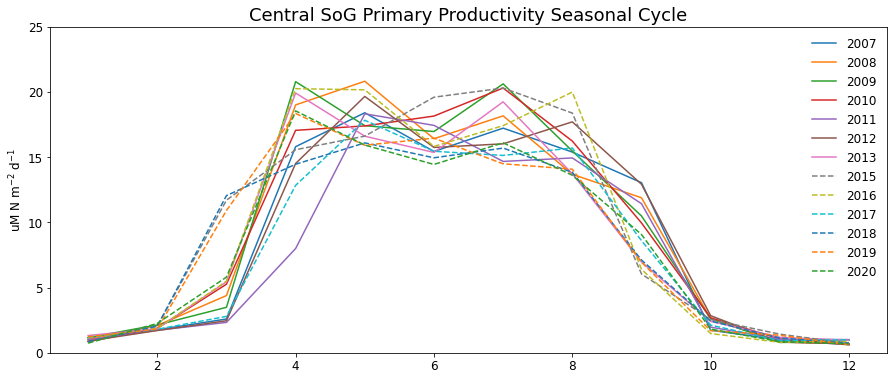

In [16]:
#plot monthly means for 5 years
fig, ax = plt.subplots(figsize=(15, 6))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


for i in range(0,7):
    ax.plot(np.arange(1,13), PProd[i,:],label=2007+i)
    ax.set_title('Central SoG Primary Productivity Seasonal Cycle',fontsize=18)
    ax.legend(frameon=False)
    ax.set_ylim(0,25)
    ax.set_ylabel('\u03bcmol N')
   
for i in range(8,14):
    ax.plot(np.arange(1,13), PProd[i,:],linestyle='--',label=2007+i)
    ax.set_title('Central SoG Primary Productivity Seasonal Cycle',fontsize=18)
    ax.legend(frameon=False)
    ax.set_ylim(0,25)
    ax.set_ylabel('uM N m$^{-2}$ d$^{-1}$')

Text(0, 0.5, 'mmol N m$^{-2}$ d$^{-1}$')

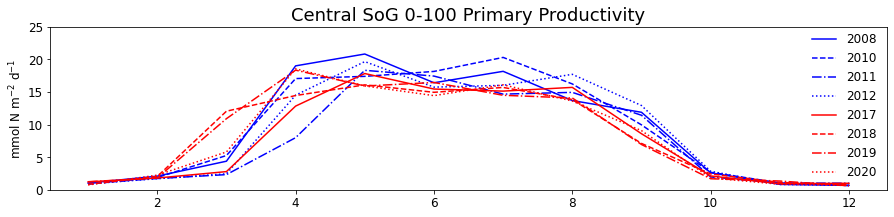

In [20]:
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


ax.plot(np.arange(1,13), PProd[1,:],color='b',linestyle='-',label='2008')
ax.plot(np.arange(1,13), PProd[3,:],color='b',linestyle='--',label='2010')
ax.plot(np.arange(1,13), PProd[4,:],color='b',linestyle='-.',label='2011')
ax.plot(np.arange(1,13), PProd[5,:],color='b',linestyle=':',label='2012')
ax.plot(np.arange(1,13), PProd[10,:],color='r',linestyle='-',label='2017')
ax.plot(np.arange(1,13), PProd[11,:],color='r',linestyle='--',label='2018')
ax.plot(np.arange(1,13), PProd[12,:],color='r',linestyle='-.',label='2019')
ax.plot(np.arange(1,13), PProd[13,:],color='r',linestyle=':',label='2020')

ax.set_title('Central SoG 0-100 Primary Productivity',fontsize=18)
ax.legend(frameon=False)
ax.set_ylim(0,25)
ax.set_ylabel('mmol N m$^{-2}$ d$^{-1}$')

Text(0, 0.5, 'mmol N m$^{-2}$ d$^{-1}$')

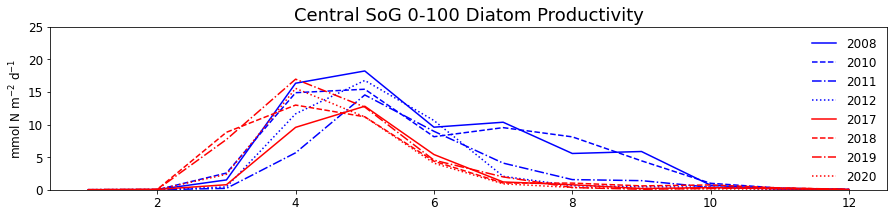

In [23]:
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


ax.plot(np.arange(1,13), monthly_array_ppdiat_depthint_slicemean[1,:]*86400,color='b',linestyle='-',label='2008')
ax.plot(np.arange(1,13), monthly_array_ppdiat_depthint_slicemean[3,:]*86400,color='b',linestyle='--',label='2010')
ax.plot(np.arange(1,13), monthly_array_ppdiat_depthint_slicemean[4,:]*86400,color='b',linestyle='-.',label='2011')
ax.plot(np.arange(1,13), monthly_array_ppdiat_depthint_slicemean[5,:]*86400,color='b',linestyle=':',label='2012')
ax.plot(np.arange(1,13), monthly_array_ppdiat_depthint_slicemean[10,:]*86400,color='r',linestyle='-',label='2017')
ax.plot(np.arange(1,13), monthly_array_ppdiat_depthint_slicemean[11,:]*86400,color='r',linestyle='--',label='2018')
ax.plot(np.arange(1,13), monthly_array_ppdiat_depthint_slicemean[12,:]*86400,color='r',linestyle='-.',label='2019')
ax.plot(np.arange(1,13), monthly_array_ppdiat_depthint_slicemean[13,:]*86400,color='r',linestyle=':',label='2020')

ax.set_title('Central SoG 0-100 Diatom Productivity',fontsize=18)
ax.legend(frameon=False)
ax.set_ylim(0,25)
ax.set_ylabel('mmol N m$^{-2}$ d$^{-1}$')

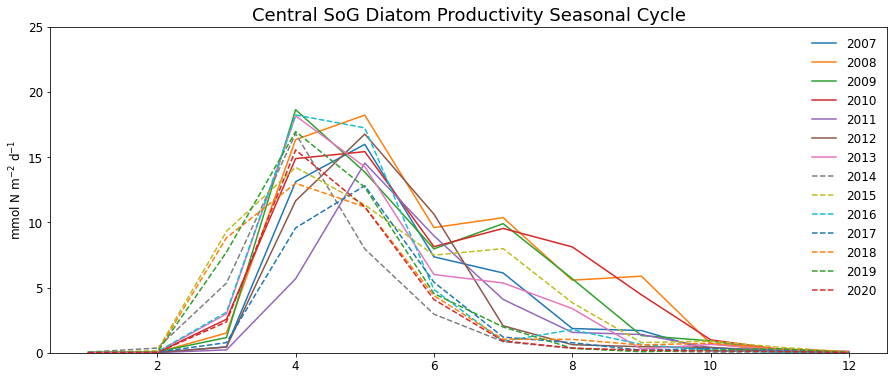

In [27]:
#plot monthly means for 5 years
fig, ax = plt.subplots(figsize=(15, 6))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]


for i in range(0,7):
    ax.plot(np.arange(1,13), monthly_array_ppdiat_depthint_slicemean[i,:]*86400,label=2007+i)
    ax.set_title('Central SoG Primary Productivity Seasonal Cycle',fontsize=18)
    ax.legend(frameon=False)
    ax.set_ylim(0,25)
    ax.set_ylabel('\u03bcmol N')
   
for i in range(7,14):
    ax.plot(np.arange(1,13), monthly_array_ppdiat_depthint_slicemean[i,:]*86400,linestyle='--',label=2007+i)
    ax.set_title('Central SoG Diatom Productivity Seasonal Cycle',fontsize=18)
    ax.legend(frameon=False)
    ax.set_ylim(0,25)
    ax.set_ylabel('mmol N m$^{-2}$ d$^{-1}$')

<ipython-input-28-10d9f4ce2526>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Jan','Feb','Apr','Jun','Aug','Oct','Dec'],fontsize=16) #where you replace axs[0] with whatever your axis is named


Text(0, 0.5, 'mmol N m$^{-2}$ d$^{-1}$')

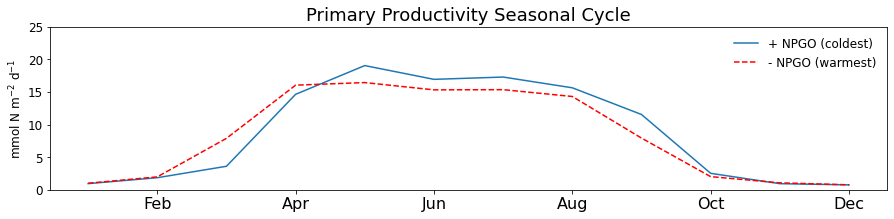

In [28]:
fig, ax = plt.subplots(figsize=(15, 3))
bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 0.9}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
ax.set_xticklabels(['Jan','Feb','Apr','Jun','Aug','Oct','Dec'],fontsize=16) #where you replace axs[0] with whatever your axis is named




ax.plot(np.arange(1,13), NPGOcoldest_PP,label='+ NPGO (coldest)')
ax.plot(np.arange(1,13), NPGOwarmest_PP,linestyle='--',label='- NPGO (warmest)',color='r')
ax.set_title('Primary Productivity Seasonal Cycle',fontsize=18)
ax.legend(frameon=False)
ax.set_ylim(0,25)
ax.set_ylabel('mmol N m$^{-2}$ d$^{-1}$')